In [1]:
import os.path as osp
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision.utils as vutils

from src.datasets import DatasetBuilder

from src.utils import seed_everything, get_config
from src.cf_methods.c3lt import models 

d:\PycharmProjects\CF-Robustness-Benchmark\venv\Lib\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
seed_everything()

plt.style.use('seaborn-v0_8-darkgrid')
params = {"text.color" : "black"}
plt.rcParams.update(params)

## Load data

In [34]:
repo_path = r"D:\PycharmProjects\CF-Robustness-Benchmark"
config_path = osp.join(repo_path, r'configs\train_classifier_mnist.yaml')
# r'/data/leuven/365/vsc36567/CF-Robustness-Benchmark/configs/train_classifier_fmnist.yaml'

config = get_config(config_path)

BATCH_SIZE = config.batch_size
img_size = config.data.img_size

In [35]:
ds_builder = DatasetBuilder(config)
ds_builder.setup()
train_loader, val_loader, test_loader = ds_builder.get_dataloaders()

In [36]:
config.data.classes

[1, 8]

In [9]:
# preprocessing
# download = True


# data_dir = r'D:\PycharmProjects\Counterfactual-Robustness-Benchmark\data'
# r"/vsc-hard-mounts/leuven-data/365/vsc36567/Counterfactual-Robustness-Benchmark/data"
# data_flag = "FashionMNIST"
# ds_names = ['train', 'val','test']
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# classes = ['all'] #[1, 8]

# datasets = {}
# for ds_name in ds_names:
#     datasets[ds_name] = FashionMNISTDataset(data_flag, 
#                                     split=ds_name, 
#                                     data_dir=data_dir, 
#                                     size=img_size, 
#                                     download=download,
#                                     increase_channels=False,
#                                     undersample=False,
#                                     channels_first=True,
#                                     classes=classes)

# # unique_targets = np.unique(datasets['train'].data.targets).tolist()
# NUM_CLASSES = len(datasets['train'].data.classes)

# print(f"{data_flag.capitalize()} dataset has been successfully loaded")
# print("Unique classes: ", datasets['train'].data.classes)

Fashionmnist dataset has been successfully loaded
Unique classes:  ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [10]:
# train_loader = DataLoader(dataset=datasets['train'], batch_size=BATCH_SIZE, shuffle=True)
# val_loader = DataLoader(dataset=datasets['val'], batch_size=BATCH_SIZE, shuffle=True) 
# test_loader = DataLoader(dataset=datasets['test'], batch_size=BATCH_SIZE, shuffle=True) 

In [37]:
z = 100
ngf = 64 # Size of feature maps in generator
ndf = 64 # Size of feature maps in discriminator
nc = 1 # Number of channels
beta1 = 0.5 # Beta1 hyperparameter for Adam optimizers
lr = 0.0002 # Learning rate for optimizers
device = 'cuda' if torch.cuda.is_available() else 'cpu' 

## Build DCGAN object  

In [38]:
# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [39]:
gen = models.Generator(latent_dim=z, ngf=ngf, nc=nc).to(device)
discr = models.Discriminator(ndf=ndf, nc=1).to(device)

gen.apply(weights_init);
discr.apply(weights_init);

In [40]:
# Initialize the ``BCELoss`` function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(BATCH_SIZE, z, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerG = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerD = torch.optim.Adam(discr.parameters(), lr=lr, betas=(beta1, 0.999))

In [41]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0
num_epochs = 15

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(train_loader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        discr.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = discr(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, z, 1, 1, device=device)
        # Generate fake image batch with G
        fake = gen(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = discr(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        gen.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = discr(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(train_loader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(test_loader)-1)):
            with torch.no_grad():
                fake = gen(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/15][0/158]	Loss_D: 1.3098	Loss_G: 1.5578	D(x): 0.5660	D(G(z)): 0.4933 / 0.2310
[0/15][50/158]	Loss_D: 0.1360	Loss_G: 4.3543	D(x): 0.9433	D(G(z)): 0.0651 / 0.0208
[0/15][100/158]	Loss_D: 0.1492	Loss_G: 3.6968	D(x): 0.9421	D(G(z)): 0.0754 / 0.0316
[0/15][150/158]	Loss_D: 0.8608	Loss_G: 8.1764	D(x): 0.9832	D(G(z)): 0.5215 / 0.0007
[1/15][0/158]	Loss_D: 0.1959	Loss_G: 4.2173	D(x): 0.9040	D(G(z)): 0.0797 / 0.0222
[1/15][50/158]	Loss_D: 0.3053	Loss_G: 4.4772	D(x): 0.8970	D(G(z)): 0.1648 / 0.0142
[1/15][100/158]	Loss_D: 0.2929	Loss_G: 2.6924	D(x): 0.8605	D(G(z)): 0.1136 / 0.0916
[1/15][150/158]	Loss_D: 0.3707	Loss_G: 2.9639	D(x): 0.8367	D(G(z)): 0.1452 / 0.0837
[2/15][0/158]	Loss_D: 0.2376	Loss_G: 3.3145	D(x): 0.9193	D(G(z)): 0.1266 / 0.0528
[2/15][50/158]	Loss_D: 0.3559	Loss_G: 3.8177	D(x): 0.9135	D(G(z)): 0.2075 / 0.0327
[2/15][100/158]	Loss_D: 0.1998	Loss_G: 3.2908	D(x): 0.9071	D(G(z)): 0.0902 / 0.0517
[2/15][150/158]	Loss_D: 0.2341	Loss_G: 2.7251	D(x): 0.8881	

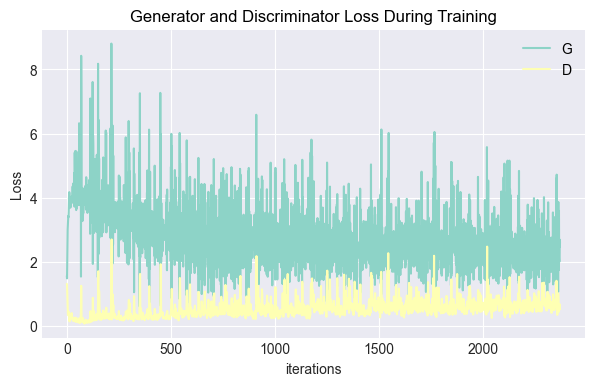

In [42]:
plt.figure(figsize=(7,4))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

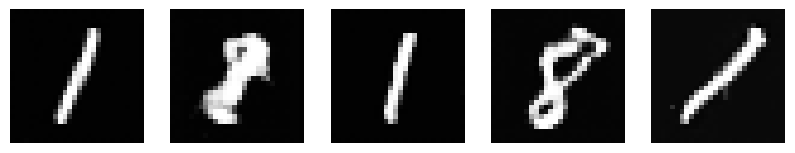

In [43]:
n_samples = 5
fig, axs = plt.subplots(1, n_samples, figsize=(10, 4))

noise_vector = torch.randn(BATCH_SIZE, z, 1, 1, device=device)
gen_images = gen(noise_vector).detach().cpu()

for j in range(n_samples):
    axs[j].imshow(gen_images[j].squeeze(0), cmap='gray')
    axs[j].axis("off")


In [44]:
save_dir = osp.join(repo_path,  r'src/cf_methods/c3lt/weights')
# r'D:\PycharmProjects\Counterfactual-Robustness-Benchmark\src\recourse_methods\c3lt\weights'
# r'/data/leuven/365/vsc36567/Counterfactual-Robustness-Benchmark/src/recourse_methods/c3lt/weights'

torch.save(gen.state_dict(), osp.join(save_dir, r'generator_mnist_1_8.pth'))
torch.save(discr.state_dict(), osp.join(save_dir, r'discriminator_mnist_1_.pth'))

## Train AE

In [45]:
ae = models.ConvolutionalAuntoencoder(latent_dim=z, nc=nc, ndf=32, ngpu=1).to(device)

In [46]:
# specify loss function
criterion = nn.MSELoss()

# specify loss function
optimizer = torch.optim.Adam(ae.parameters(), lr=0.001)

# number of epochs to train the model
n_epochs = 30

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    

    for data in tqdm(train_loader):
        images, _ = data
        images = images.to(device)

        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        outputs = ae(images)
        loss = criterion(outputs, images)

        loss.backward()
        optimizer.step()
        train_loss += loss.item()*images.size(0)
            
    # print avg training statistics 
    train_loss = train_loss/len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))


100%|██████████| 158/158 [00:05<00:00, 28.34it/s]


Epoch: 1 	Training Loss: 30.924112


100%|██████████| 158/158 [00:05<00:00, 29.28it/s]


Epoch: 2 	Training Loss: 17.540005


100%|██████████| 158/158 [00:05<00:00, 30.30it/s]


Epoch: 3 	Training Loss: 10.199658


100%|██████████| 158/158 [00:05<00:00, 28.71it/s]


Epoch: 4 	Training Loss: 5.602707


100%|██████████| 158/158 [00:06<00:00, 24.45it/s]


Epoch: 5 	Training Loss: 2.919363


100%|██████████| 158/158 [00:05<00:00, 28.48it/s]


Epoch: 6 	Training Loss: 1.466313


100%|██████████| 158/158 [00:05<00:00, 28.61it/s]


Epoch: 7 	Training Loss: 0.744586


100%|██████████| 158/158 [00:05<00:00, 28.31it/s]


Epoch: 8 	Training Loss: 0.419750


100%|██████████| 158/158 [00:05<00:00, 27.75it/s]


Epoch: 9 	Training Loss: 0.287064


100%|██████████| 158/158 [00:05<00:00, 27.32it/s]


Epoch: 10 	Training Loss: 0.241192


100%|██████████| 158/158 [00:05<00:00, 28.96it/s]


Epoch: 11 	Training Loss: 0.217060


100%|██████████| 158/158 [00:05<00:00, 28.63it/s]


Epoch: 12 	Training Loss: 0.205673


100%|██████████| 158/158 [00:05<00:00, 28.76it/s]


Epoch: 13 	Training Loss: 0.199972


100%|██████████| 158/158 [00:05<00:00, 28.45it/s]


Epoch: 14 	Training Loss: 0.195360


100%|██████████| 158/158 [00:05<00:00, 28.23it/s]


Epoch: 15 	Training Loss: 0.191749


100%|██████████| 158/158 [00:05<00:00, 27.58it/s]


Epoch: 16 	Training Loss: 0.181214


100%|██████████| 158/158 [00:05<00:00, 27.99it/s]


Epoch: 17 	Training Loss: 0.179340


100%|██████████| 158/158 [00:05<00:00, 27.73it/s]


Epoch: 18 	Training Loss: 0.176704


100%|██████████| 158/158 [00:05<00:00, 27.80it/s]


Epoch: 19 	Training Loss: 0.173688


100%|██████████| 158/158 [00:06<00:00, 26.22it/s]


Epoch: 20 	Training Loss: 0.168378


100%|██████████| 158/158 [00:05<00:00, 28.56it/s]


Epoch: 21 	Training Loss: 0.165213


100%|██████████| 158/158 [00:05<00:00, 27.75it/s]


Epoch: 22 	Training Loss: 0.160637


100%|██████████| 158/158 [00:05<00:00, 27.97it/s]


Epoch: 23 	Training Loss: 0.155803


100%|██████████| 158/158 [00:05<00:00, 27.95it/s]


Epoch: 24 	Training Loss: 0.153894


100%|██████████| 158/158 [00:05<00:00, 28.09it/s]


Epoch: 25 	Training Loss: 0.149047


100%|██████████| 158/158 [00:05<00:00, 28.04it/s]


Epoch: 26 	Training Loss: 0.146734


100%|██████████| 158/158 [00:05<00:00, 28.41it/s]


Epoch: 27 	Training Loss: 0.144967


100%|██████████| 158/158 [00:05<00:00, 28.02it/s]


Epoch: 28 	Training Loss: 0.140111


100%|██████████| 158/158 [00:05<00:00, 28.22it/s]


Epoch: 29 	Training Loss: 0.139155


100%|██████████| 158/158 [00:05<00:00, 27.66it/s]

Epoch: 30 	Training Loss: 0.136385


Recon loass: 0.00178


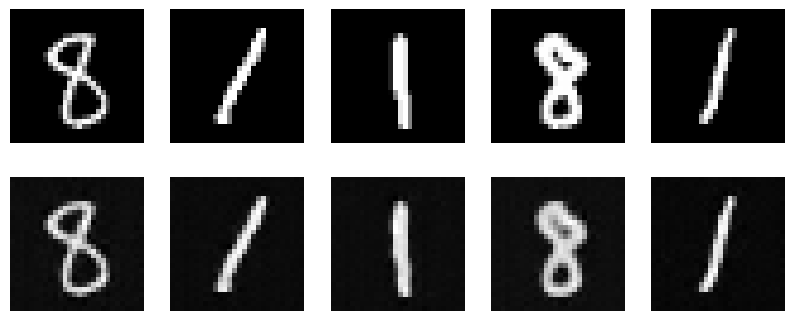

In [47]:
n_samples = 5
fig, axs = plt.subplots(2, n_samples, figsize=(10, 4))

images, _ = next(iter(train_loader))
recon = ae(images.to(device)).detach().cpu()
recon_loss = criterion(images, recon).item()

for j in range(n_samples):
    axs[0, j].imshow(images[j].squeeze(0), cmap='gray')
    axs[0, j].axis("off")
    axs[1, j].imshow(recon[j].squeeze(0), cmap='gray')
    axs[1, j].axis("off")

print(f'Recon loass: {recon_loss:.5f}')


In [48]:
save_dir = osp.join(repo_path, './src/cf_methods/c3lt/weights')
torch.save(ae.state_dict(), osp.join(save_dir, 'ae_mnist_1_8.pth'))
torch.save(ae.encoder.state_dict(), osp.join(save_dir, 'encoder_mnist_1_8.pth'))